Task 4: Quantum Convolutional Neural Network for Sine Function [0, 2π].

Epoch 1/50
25/25 - 12s - 478ms/step - loss: 0.9113 - mae: 0.8559 - val_loss: 0.8176 - val_mae: 0.8212
Epoch 2/50
25/25 - 1s - 42ms/step - loss: 0.6386 - mae: 0.7166 - val_loss: 0.5658 - val_mae: 0.6830
Epoch 3/50
25/25 - 2s - 92ms/step - loss: 0.4327 - mae: 0.5897 - val_loss: 0.3776 - val_mae: 0.5585
Epoch 4/50
25/25 - 2s - 74ms/step - loss: 0.2831 - mae: 0.4768 - val_loss: 0.2434 - val_mae: 0.4490
Epoch 5/50
25/25 - 1s - 32ms/step - loss: 0.1786 - mae: 0.3787 - val_loss: 0.1512 - val_mae: 0.3541
Epoch 6/50
25/25 - 1s - 33ms/step - loss: 0.1086 - mae: 0.2952 - val_loss: 0.0905 - val_mae: 0.2739
Epoch 7/50
25/25 - 1s - 33ms/step - loss: 0.0635 - mae: 0.2256 - val_loss: 0.0520 - val_mae: 0.2077
Epoch 8/50
25/25 - 1s - 50ms/step - loss: 0.0357 - mae: 0.1691 - val_loss: 0.0287 - val_mae: 0.1544
Epoch 9/50
25/25 - 1s - 33ms/step - loss: 0.0193 - mae: 0.1242 - val_loss: 0.0152 - val_mae: 0.1123
Epoch 10/50
25/25 - 1s - 33ms/step - loss: 0.0100 - mae: 0.0893 - val_loss: 0.0077 - val_mae: 0.08

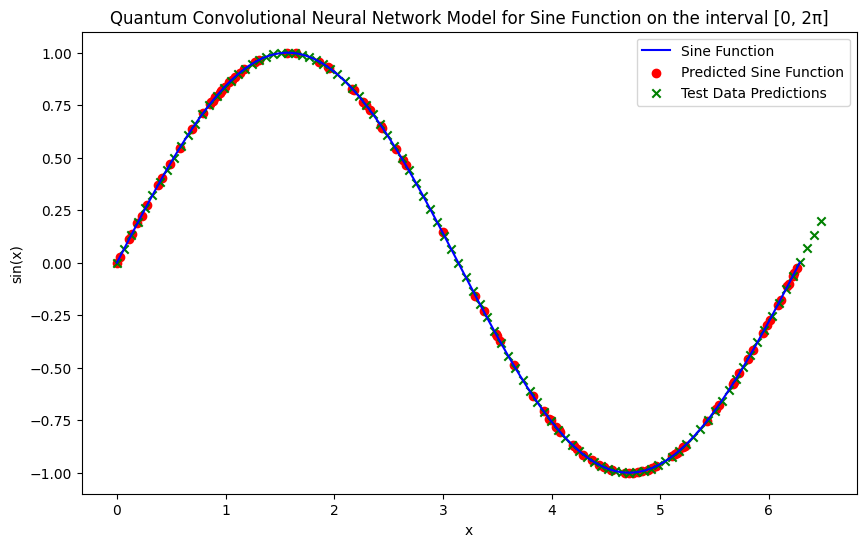

In [4]:
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import tensorflow as tf
import matplotlib.pyplot as plt

# Suppress TensorFlow warnings and logs
tf.get_logger().setLevel("ERROR")

# Set seeds for reproducibility
np.random.seed(42)
pnp.random.seed(42)
tf.random.set_seed(42)

# Discretize the interval [0, 2π]
x_values = np.linspace(0, 2 * np.pi, 500)  # 500 points between 0 and 2π
y_values = np.sin(x_values)  # Compute the sine of these points

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.2, random_state=42)
# 80% of the data for training and 20% for testing

# Ensure the data is in the correct shape and type for TensorFlow
x_train = np.expand_dims(x_train, axis=-1).astype(np.float32)  # Expand dims and cast to float32
x_test = np.expand_dims(x_test, axis=-1).astype(np.float32)    # Expand dims and cast to float32
y_train = y_train.astype(np.float32)  # Cast y_train to float32
y_test = y_test.astype(np.float32)    # Cast y_test to float32

# Define the quantum device
n_qubits = 4  # Number of qubits for the quantum circuit
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum node
@qml.qnode(dev, interface='tf')
def quantum_conv_circuit(inputs, weights):
    """
    Quantum circuit with angle embedding and basic entangler layers.

    Args:
    inputs (array): The input features for the quantum circuit.
    weights (array): The trainable weights for the quantum circuit.

    Returns:
    list: The expectation values of the PauliZ measurement on each qubit.
    """
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))  # Embed inputs as rotations on the qubits
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))  # Apply entangling layers
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]  # Measure the expectation value of PauliZ

# Define a hybrid quantum-Classical model
class QuantumModel(tf.keras.Model):
    """
    Hybrid quantum-classical neural network model.

    This model integrates a quantum convolutional layer with a classical dense layer.

    Attributes:
    n_qubits (int): Number of qubits in the quantum circuit.
    n_layers (int): Number of layers in the quantum circuit.
    q_weights (tf.Variable): Trainable weights for the quantum circuit.
    flatten (tf.keras.layers.Flatten): Flatten layer for the quantum circuit output.
    dense (tf.keras.layers.Dense): Dense output layer.
    """
    def __init__(self, n_qubits, n_layers):
        """
        Initialize the hybrid quantum-classical model.

        Args:
        n_qubits (int): Number of qubits in the quantum circuit.
        n_layers (int): Number of layers in the quantum circuit.
        """
        super(QuantumModel, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.q_weights = tf.Variable(
            initial_value=tf.random.normal(shape=(n_layers, n_qubits), dtype=tf.float32),
            trainable=True, name='q_weights'
        )  # Initialize trainable quantum weights
        self.flatten = tf.keras.layers.Flatten()  # Flatten layer
        self.dense = tf.keras.layers.Dense(1, activation='linear')  # Dense output layer

    def call(self, inputs):
        """
        Forward pass of the model.

        Args:
        inputs (tf.Tensor): Input features.

        Returns:
        tf.Tensor: Output predictions.
        """
        inputs = tf.cast(inputs, dtype=tf.float32)  # Ensure inputs are float32
        q_out = tf.map_fn(lambda x: tf.cast(quantum_conv_circuit(x, self.q_weights), tf.float32),
                          inputs, fn_output_signature=tf.TensorSpec(shape=(n_qubits,), dtype=tf.float32))
        # Apply the quantum circuit to each input and cast the output to float32
        q_out = self.flatten(q_out)  # Flatten the output
        return self.dense(q_out)  # Pass through the dense layer

# Initialize the hybrid model
n_layers = 5  # Number of layers in the quantum circuit
QCNN_model = QuantumModel(n_qubits, n_layers)

# Compile the model
QCNN_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
# Use Adam optimizer, mean squared error loss, and mean absolute error metric

# Train the model
history = QCNN_model.fit(x_train, y_train, epochs=50, batch_size=16, validation_data=(x_test, y_test), verbose=2)
# Train the model for 50 epochs with a batch size of 16, using the training data and validating on the test data

# Predict the values
y_pred = QCNN_model.predict(x_test)

# Calculate R² score
r2 = r2_score(y_test, y_pred)

# Print the R² score
print(f"R² score: {r2:.4f}")

# Additional test data points
X_test = np.linspace(0, 2 * np.pi + 0.2, 100)  # 100 points for additional testing
Y_test = np.sin(X_test)  # Compute the sine of these points

# Expand dimensions for consistency
X_test = np.expand_dims(X_test, axis=-1)
Y_test = Y_test.astype(np.float32)

# Predict the values for additional test points
Y_pred_test = QCNN_model.predict(X_test)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='Sine Function', color='blue')  # Plot the true sine values
plt.scatter(x_test, y_pred, label='Predicted Sine Function', color='red')  # Plot the predicted sine values
plt.scatter(X_test, Y_pred_test, label='Test Data Predictions', color='green', marker='x')  # Plot additional test predictions
plt.title('Quantum Convolutional Neural Network Model for Sine Function on the interval [0, 2π]')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()
plt.show()


#### Our hybrid quantum-classical model demonstrates exceptional accuracy in predicting the sine function across the interval [0, 2π], achieving a perfect R² score. This indicates an excellent fit to the data and the model's ability to capture the function's periodic nature. While this result is promising, it's essential to consider the potential for overfitting, where a model becomes overly attuned to the training data. However, due to the simplicity and smoothness of the sine function, overfitting is less likely in this case. This achievement underscores the potential of quantum-classical hybrid models for regression tasks. To expand on this success, we will adapt the model for more complex challenges, such as defect detection in industrial datasets. By leveraging quantum-enhanced feature extraction and classical processing techniques, we aim to develop a robust and efficient quantum machine learning solution for identifying defective production parts.

